# PyArrow

- https://arrow.apache.org/
- Pasos de instalación
- Descripción del producto, modo de funcionamiento, mostrar cómo describir los esquemas
- Mostrar cómo importar los datos de Stackoverflow
- Mostrar posibles optimizaciones para realizar RQ1 a RQ4 vistos en la sesión 2


## Pasos de Instalación

La instalación de PyArrow (a 26 de noviembre de 2024 se recomienda la versión `18.1`) es simple, y viene detallada en su [página web](https://arrow.apache.org/install/), estando disponible (a la misma fecha) para Python desde su versión `3.9` hasta la `3.13`.

Existen tres paquetes de PyArrow disponibles para Python, con menor o mayor cantidad de componentes de Arrow integrados, que podemos instalar, aunque también podemos instalar estos componentes individualmente. Estos paquetes son los siguientes:

**Componente** | **Paquete** | `pyarrow-core` | `pyarrow` | `pyarrow-all`
---------|----------|:--------:|:-------:|:-------:
Core | pyarrow-core | ✅ | ✅ | ✅
Parquet | libparquet |  | ✅ | ✅
Dataset | libarrow-dataset |  | ✅ | ✅
Acero | libarrow-acero |  | ✅ | ✅
Substrait | libarrow-substrait |  | ✅ | ✅
Flight | libarrow-flight |  |  | ✅
Flight SQL | libarrow-flight-SQL |  |  | ✅
Gandiva | libarrow-gandiva |  |  | ✅

Según el entorno de desarrollo y el entorno virtual que utilicemos usaremos **pip** o **conda** para instalar el paquete:

- Instalación con **pip**: `pip install pyarrow==18.1.*`
- Instalación con **conda**: `conda install pyarrow=18.1.* -c conda-forge`

En la instalación se incluyen los binarios de las librerías `Apache Arrow` y `Apache Parquet` de C++. 

PyArrow tiene las siguientes dependencias opcionales:
- `NumPyy 1.16.6` o mayor
- `pandas 1.0` o mayor
- `cffi` (permite interactuar con código de C en Python)

Además también podemos acceder al código fuente de Arrow y sus diferentes implementaciones en su [repositorio de Github](https://github.com/apache/arrow).

### Instalación de Librerías Necesarias 
A continuación, instalamos las librerías necesarias para ejecutar el notebook.

In [2]:
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install pandas
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## ¿Qué es PyArrow?
PyArrow es la implementación de **Apache Arrow** para **Python**, por lo que para poder explicar qué es PyArrow debemos conocer primero Apache Arrow.

Apache Arrow es, según su página web, una plataforma de desarrollo de software para construir aplicaciones de gran rendimiento que procesan y transportan grandes conjuntos de datos. Está diseñado para mejorar el rendimiento de los algoritmos de análisis y para eficiencia al mover datos de un sistema o lenguaje de programación a otro. 

En la práctica, se utiliza para mejorar el rendimiento y la interoperabilidad entre diferentes herramientas de procesamiento de datos dado que el formato Arrow tiene implementación en la mayoría de lenguajes de programación modernos y más utilizados, como Python, R, Julia, Rust, Go, Java, C++, C, C# o Ruby.

Arrow destaca por la forma en la que almacena los datos en memoría, ya que lo hace en formato columnar, lo que permite un acceso más rápido y eficiente en grandes cargas de trabajo analíticas, permitiendo representar conjuntos de datos estructurados en formatos semejantes a tablas. Además, es *language-agnostic*, por lo que soporta diferentes lenguajes y facilita el intercambio de datos entre diferentes aplicaciones sin la necesidad de una gran cantidad de recursos. También aseguran la retrocompatibilidad del formato al añadir solo actualizaciones no destructivas, como la adición de nuevos tipos de datos.

PyArrow es la implementación de Apache Arrow en Python. Es una biblioteca que permite trabajar con el formato Arrow y su ecosistema desde Python, y está construida sobre la librería de Arrow en C++ (similar a lo que ocurre con la librería `numpy`), permitiendo así un tratamiento de datos más rápido.

PyArrow permite la creación y manipulación de estructuras de datos Arrow directamente en Python, permitiendo trabajar con ellas con operaciones paralelas y destacando su fácil conversión en `DataFrames` de la librería `pandas` y con `pySpark`, por lo que permite enlazar con las técnicas de análisis de datos distribuidos que ofrece Spark. De igual forma, PyArrow permite trabajar con los formatos de datos más comunes, como son CSV y Parquet.

### Descripción de Esquemas

Un `Schema`, o esquema, en PyArrow es una estructura que describe la organización de los datos en una tabla o un set de datos. Es esencialmente una representación de los metadatos de las columnas, definiendo aspectos como sus nombres, tipo de datos y, opcionalmente, metadatos adicionales.

Los esquemas son útiles para garantizar la coherencia en el manejo de datos y para validar que los datos cumplan con una estructura predefinida antes de ser procesados. En este aspecto, son muy similares a los esquemas definidos en SQL.

Definimos un esquema usando función `schema` de PyArrow, que genera un objeto de la clase `Schema`, donde introducimos los nombres de las columnas, los tipos de éstas, y opcionalmente metadatos en forma de pares clave-valor.

In [2]:
import pyarrow as pa

sc = pa.schema([
    ("nombre", pa.string()),
    ("edad", pa.int32()),
    ("peso", pa.float32()),
], metadata = {
    "descripcion": "Esquema que representa los datos de una persona",
    "peso" : "En kilogramos"
})
sc

nombre: string
edad: int32
peso: float
-- schema metadata --
descripcion: 'Esquema que representa los datos de una persona'
peso: 'En kilogramos'

Podemos asociar esquemas a `Table`s, las estructuras principales de PyArrow que veremos a continuación, de forma que se verifiquen los datos que se importen. En caso de que los datos no coincidan con el esquema definido, PyArrow lanzará un error. Es decir, usando esquemas aseguramos la coherencia de los datos.

In [3]:
data = {
    "nombre": ["Maria", "Luis"],
    "edad": [25, 30],
    "peso": [65.8, 85.6]
}

table = pa.Table.from_pydict(data, schema=sc)
table.schema

nombre: string
edad: int32
peso: float
-- schema metadata --
descripcion: 'Esquema que representa los datos de una persona'
peso: 'En kilogramos'

Se pueden *castear* una tabla para forzarla a adoptar un nuevo esquema, variando los tipos de datos de las columnas:

In [4]:
sc_int8 = pa.schema([
    ("nombre", pa.string()),
    ("edad", pa.int8()),
    ("peso", pa.float32()),
])

table_int8 = table.cast(sc_int8)
table_int8

pyarrow.Table
nombre: string
edad: int8
peso: float
----
nombre: [["Maria","Luis"]]
edad: [[25,30]]
peso: [[65.8,85.6]]

Los esquemas son inmutables, pero podemos crear esquemas nuevos al aplicar transformaciones a esquemas ya definidos para definir nuevas columnas, eliminarlas, cambiar los metadatos, cambiar el tipo de datos de una columna e incluso unir esquemas (mantiene los metadatos del primer esquema).

In [5]:
sc2 = (
    sc.remove(2)
    .append(pa.field("altura", pa.float32()))
    .with_metadata(
        {
            "descripcion": "Esquema que representa los datos de una persona",
            "altura": "en metros",
        }
    )
)
sc2

nombre: string
edad: int32
altura: float
-- schema metadata --
descripcion: 'Esquema que representa los datos de una persona'
altura: 'en metros'

In [6]:
sc3 = pa.schema([
    ("pais", pa.string()),
    ("municipio", pa.string()),
    ("zipcode", pa.int16()),
    ("puerta", pa.string()),
    ], metadata = {
        "cosas": "cosas",
    }
)
# Vease que sc no ha cambiado
uni_sc = pa.unify_schemas([sc,sc3])
uni_sc

nombre: string
edad: int32
peso: float
pais: string
municipio: string
zipcode: int16
puerta: string
-- schema metadata --
descripcion: 'Esquema que representa los datos de una persona'
peso: 'En kilogramos'

### Funcionamiento
Como hemos dicho, PyArrow es un paquete de Python que funciona como una interfaz para manejar datos usando el formato Apache Arrow. Al funcionar sobre la librería de Apache Arrow para C++, es rápido y eficiente a la hora de manejar datos tanto en la memoría como en el disco, al aprovechar las ventajas tanto de Apache Arrow como de C++.

#### Estructuras de Datos Básicas
Las dos estructuras básicas para manejar datos de PyArrow son las `Table`s y los `Array`s. Una `Table` representa datos en forma de tabla, de forma similar a los `DataFrames` de pandas, mientras `Array` representaría una única columna de datos con un único tipo, de forma paralela a las `Series` de pandas. Sin embargo, existe una diferencia principal entre ellas, y es que las estructuras de PyArrow son **inmutables**, lo cual es clave a la hora de garantizar la integridad de los datos y mejorar el rendimiento.

Como hemos visto, podemos crear una `Table` a partir de  un diccionario de Python, de forma muy parecida a como lo hacíamos en pandas, y un `Array` a partir de una lista:

In [7]:
import numpy as np
import pyarrow as pa

array = pa.array([1, 2, 3, 4, 5])

ex_dict = {
    "manzanas": [2,7,3,4],
    "kiwis": [3,2,1,5],
    "limones": [2,3,8,9],
    "brevas": [6,3,1,9],
}

table = pa.Table.from_pydict(ex_dict)
table

pyarrow.Table
manzanas: int64
kiwis: int64
limones: int64
brevas: int64
----
manzanas: [[2,7,3,4]]
kiwis: [[3,2,1,5]]
limones: [[2,3,8,9]]
brevas: [[6,3,1,9]]

También podemos generar `Table`s mediante la combinación de diferentes `Array`s:

In [8]:
np.random.seed(42069)
arrays = [list(map(round, np.random.normal(10,3,10))) for _ in range(4)]
table = pa.Table.from_arrays(arrays, names = ['manzanas', 'kiwis', 'limones', 'brevas'])
table

pyarrow.Table
manzanas: int64
kiwis: int64
limones: int64
brevas: int64
----
manzanas: [[10,9,11,12,13,8,12,9,4,14]]
kiwis: [[4,10,11,5,8,14,11,9,5,12]]
limones: [[9,12,13,10,6,16,6,9,11,9]]
brevas: [[12,8,15,15,14,10,9,9,9,6]]

Como vemos, la presentación de las tablas de PyArrow no es tan clara y estelística como podríamos desear. Podemos solucionar esto mediante una de las grandes ventajas de PyArrow, que es su compatibilidad con pandas:

In [9]:
import pandas as pd

df = table.to_pandas()
df

,manzanas,kiwis,limones,brevas
0,10,4,9,12
1,9,10,12,8
2,11,11,13,15
3,12,5,10,15
4,13,8,6,14
5,8,14,16,10
6,12,11,6,9
7,9,9,9,9
8,4,5,11,9
9,14,12,9,6


Esta compatibilidad es bidireccional, es decir, también podemos una `Table` de PyArrow desde un `DataFrame` de pandas:

In [10]:
table2 = pa.Table.from_pandas(df)
table2

pyarrow.Table
manzanas: int64
kiwis: int64
limones: int64
brevas: int64
----
manzanas: [[10,9,11,12,13,8,12,9,4,14]]
kiwis: [[4,10,11,5,8,14,11,9,5,12]]
limones: [[9,12,13,10,6,16,6,9,11,9]]
brevas: [[12,8,15,15,14,10,9,9,9,6]]

Finalmente, debemos mencionar los `Dataset`s de PyArrow, los cuales son abstracciones diseñadas para trabajar con colecciones de tablas distribuidas en múltiples archivos o particiones, permitiendo la compatibilidad con sistemas distribuidos como HDFS. Veremos más sobre ellos más tarde.

### Escritura y Lectura de Datos
PyArrow es compatible con una gran cantidad de formatos, y la lectura de datos se realiza de forma muy similar en todas ellas. Vamos a destacar y detallar algunas de ellas especialmente interesantes.

#### **CSV**
Es uno de los formatos más comúnmente usados para guardar datos, por lo que su estudio es relevante. Además, las opciones que vemos con los archivos CSV se pueden generar a otros formatos. 

**Escritura**

Para poder usar el módulo `csv` de PyArrow primero debemos importarlo, aunque no lo usemos explícitamente, o bien podemos importar las funciones a utilizar directamente.

In [ ]:
from pyarrow.csv import WriteOptions, write_csv

write_csv(
    data=table,
    output_file="frutas.csv",
    write_options=WriteOptions(include_header=True),
)

**Lectura**

Para leer los datos podemos especificar un esquema mediante la clase `ConvertOptions`, o en caso de no hacerlo, PyArrow tratará de inferir los tipos de las diferentes columnas.

In [15]:
from pyarrow.csv import read_csv

read_table = read_csv("frutas.csv")
read_table

pyarrow.Table
manzanas: int64
kiwis: int64
limones: int64
brevas: int64
----
manzanas: [[10,9,11,12,13,8,12,9,4,14]]
kiwis: [[4,10,11,5,8,14,11,9,5,12]]
limones: [[9,12,13,10,6,16,6,9,11,9]]
brevas: [[12,8,15,15,14,10,9,9,9,6]]

In [39]:
from pyarrow.csv import ConvertOptions

schema = pa.schema( [
        ("manzanas", pa.int8()),
        ("kiwis", pa.int8()),
        ("limones", pa.int8()),
        ("brevas", pa.int8()),
    ])

fruits_table = read_csv("frutas.csv", 
                      convert_options=ConvertOptions(column_types=schema))
fruits_table

pyarrow.Table
manzanas: int8
kiwis: int8
limones: int8
brevas: int8
----
manzanas: [[10,9,11,12,13,8,12,9,4,14]]
kiwis: [[4,10,11,5,8,14,11,9,5,12]]
limones: [[9,12,13,10,6,16,6,9,11,9]]
brevas: [[12,8,15,15,14,10,9,9,9,6]]

#### **Feather**

El formato Feather es un formato de almacenamiento de datos tabulares desarrollado conjuntamente por Apache Arrow y pandas.

Está diseñado para ser un formato rápido, eficiente y ligero, siendo particularmente útil en flujos de trabajo donde se necesita transferir grandes volúmenes de datos entre Python y cualquier otro lenguaje que soporte Apache Arrow, manteniendo el rendimiento y la interoperabilidad.

Su uso es extremadamente simple, tanto en la escritura como en la lectura.

In [31]:
import pyarrow.feather as ft

# Escritura
ft.write_feather(table, "años.feather")
# Lectura
feather_table = ft.read_table("años.feather")
feather_table

pyarrow.Table
day: int64
month: int64
----
day: [[11,8,20,21,14,22,5,27,28,22],[29,30,18,17,8,21,6,29,18,12],...,[16,6,13,26,25,13,3,25,10,22],[29,28,30,7,18,30,24,17,22,19]]
month: [[11,1,8,8,2,11,6,3,11,7],[3,6,9,4,11,7,9,5,2,9],...,[3,1,1,5,9,1,6,8,3,11],[5,4,10,9,7,1,5,8,11,11]]

#### **Particiones**

Cuando tenemos un set de datos grande podemos querer guardarlo en diferentes archivos. Esto se puede hacer automáticamente en PyArrow utilizando los `Dataset`s.

Para ello debemos especificar un esquema que diga a PyArrow por qué columna queremos particionar nuestro dataset y el formato de los archivos.

In [24]:
import pyarrow.dataset as ds

base_dir = "./particionado"
# Set de fechas con 10 entradas para cada año entre el 2000 y el 2009
data = pa.table({"day": np.random.randint(1, 31, size=100),
                 "month": np.random.randint(1, 12, size=100),
                 "year": [2000 + x // 10 for x in range(100)]})

ds.write_dataset(data, base_dir=base_dir, format="csv",
                 partitioning=ds.partitioning(pa.schema([("year",pa.int16())])))

Podemos importar el dataset completo especificando el directorio base y luego convertirlo a una tabla con todos los datos que lo componen.

In [34]:
dataset = ds.dataset(base_dir, format='csv')
print("Archivos que componen el dataset:")
print(dataset.files)
table = dataset.to_table()
print("\n\nTabla leída:")
table

Archivos que componen el dataset:
['./particionado/2000/part-0.csv', './particionado/2001/part-0.csv', './particionado/2002/part-0.csv', './particionado/2003/part-0.csv', './particionado/2004/part-0.csv', './particionado/2005/part-0.csv', './particionado/2006/part-0.csv', './particionado/2007/part-0.csv', './particionado/2008/part-0.csv', './particionado/2009/part-0.csv']


Tabla leída:


pyarrow.Table
day: int64
month: int64
----
day: [[11,8,20,21,14,22,5,27,28,22],[29,30,18,17,8,21,6,29,18,12],...,[16,6,13,26,25,13,3,25,10,22],[29,28,30,7,18,30,24,17,22,19]]
month: [[11,1,8,8,2,11,6,3,11,7],[3,6,9,4,11,7,9,5,2,9],...,[3,1,1,5,9,1,6,8,3,11],[5,4,10,9,7,1,5,8,11,11]]

Convertir un dataset a una tabla directamente es peligroso, dado que generalmente en los casos que usemos datasets serán en los que la tabla completa sea extremadamente grande y posiblemente no quepa completa en memoria. Es por ello que es más seguro trabajar con el dataset por lotes.

In [30]:
for batch in dataset.to_batches():
    print(batch)

pyarrow.RecordBatch
day: int64
month: int64
----
day: [11,8,20,21,14,22,5,27,28,22]
month: [11,1,8,8,2,11,6,3,11,7]
pyarrow.RecordBatch
day: int64
month: int64
----
day: [29,30,18,17,8,21,6,29,18,12]
month: [3,6,9,4,11,7,9,5,2,9]
pyarrow.RecordBatch
day: int64
month: int64
----
day: [8,25,19,2,21,17,25,17,5,2]
month: [8,11,8,5,5,9,11,8,4,9]
pyarrow.RecordBatch
day: int64
month: int64
----
day: [24,22,30,5,15,5,27,2,3,14]
month: [5,11,8,8,2,5,8,11,2,6]
pyarrow.RecordBatch
day: int64
month: int64
----
day: [5,22,4,9,30,22,19,16,7,20]
month: [11,9,9,7,6,4,3,2,3,6]
pyarrow.RecordBatch
day: int64
month: int64
----
day: [24,16,13,13,11,12,27,3,16,1]
month: [2,1,4,7,9,9,9,8,4,1]
pyarrow.RecordBatch
day: int64
month: int64
----
day: [1,14,12,22,26,26,12,24,18,24]
month: [1,7,6,9,7,2,4,4,3,1]
pyarrow.RecordBatch
day: int64
month: int64
----
day: [29,4,16,2,20,24,20,24,27,24]
month: [2,6,4,5,1,4,7,7,4,2]
pyarrow.RecordBatch
day: int64
month: int64
----
day: [16,6,13,26,25,13,3,25,10,22]
month: [

### Operaciones con PyArrow

Las operaciones se realizan en memoria directamente sobre las estructuras de datos de Arrow, utilizando funciones optimizadas para el procesamiento en lotes y sin necesidad de copias intermedias de datos.

El conjunto de operaciones que se pueden utilizar en PyArrow se encuentran en el módulo `pyarrow.compute`, a continuación mostramos las más comunes.

> Cabe mencionar que vscode da problemas al reconocer algunos de los métodos y funciones al realizar imports

#### Filtrado
Usamos la función `filter` y añadimos una condición con los operadores de `pyarrow.compute`. `filter` devuelve una tabla directamente, no afecta a la tabla original. Estos filtros se pueden aplicar también sobre datasets para obtener solamente los datos que pasan el filtro como una tabla.

In [46]:
import pyarrow.compute as pc
# Creamos una tabla para aplicar filtros
data = {
    "name": ["Alice", "Bob", "Charlie", "David"],
    "age": [25, 30, 35, 40],
    "city": ["NY", "LA", "NY", "SF"]
}
table = pa.Table.from_pydict(data)

pc.filter(table, pc.greater(table['age'], 30))

pyarrow.Table
name: string
age: int64
city: string
----
name: [["Charlie","David"]]
age: [[35,40]]
city: [["NY","SF"]]

Otra forma de realizar operaciones es mediante expresiones.

In [54]:
expr = pc.field("age") > 30
table.filter(expr)

pyarrow.Table
name: string
age: int64
city: string
----
name: [["Charlie","David"]]
age: [[35,40]]
city: [["NY","SF"]]

#### Filtros compuestos

Podemos combinar filtros usando los operadores `and_` y `or_`, o expresiones con los operadores `&` (and), `|` (or) y `~` (not).

In [ ]:
expr = (pc.field("age") > 30) & \
       (pc.field('city') == 'NY')

table.filter(expr)

pyarrow.Table
name: string
age: int64
city: string
----
name: [["Charlie"]]
age: [[35]]
city: [["NY"]]

#### Agregaciones

Podemos realizar agregaciones sobre arrays. Estos devuelven un tipo asociado a PyArrow, por lo que para convertirlos a tipos de Python debemos llamar al método `as_py`.

In [62]:
pc.mean(table['age']).as_py()

32.5

#### Operaciones con Arrays
También podemos realizar operaciones aritméticas con arrays.

In [64]:
double_age = pc.multiply(table['age'], 2)
double_age

[
  [
    50,
    60,
    70,
    80
  ]
]

#### Concatenación de Tablas
Podemos unir dos tablas que sigan el mismo esquema con `concat_tables`.

In [65]:
oscar_nominations_1 = pa.table([
  ["Meryl Streep", "Katharine Hepburn"],
  [21, 12]
], names=["actor", "nominations"])

oscar_nominations_2 = pa.table([
  ["Jack Nicholson", "Bette Davis"],
  [12, 10]
], names=["actor", "nominations"])

pa.concat_tables([oscar_nominations_1, oscar_nominations_2])

pyarrow.Table
actor: string
nominations: int64
----
actor: [["Meryl Streep","Katharine Hepburn"],["Jack Nicholson","Bette Davis"]]
nominations: [[21,12],[12,10]]

#### Añadir y Modificar Columnas

In [70]:
# Añadir columnas
oscar_nominations = oscar_nominations_1.append_column(
    "wonyears", pa.array([
        [1980, 1983, 2012], 
        [1934, 1968, 1969, 1982]
]))
oscar_nominations

pyarrow.Table
actor: string
nominations: int64
wonyears: list<item: int64>
  child 0, item: int64
----
actor: [["Meryl Streep","Katharine Hepburn"]]
nominations: [[21,12]]
wonyears: [[[1980,1983,2012],[1934,1968,1969,1982]]]

In [74]:
# Modificar la columna 0
oscar_nominations.set_column(0, "full_name", 
                             pa.array(["Mary Louise Streep", "Katharine Houghton Hepburn"]))

pyarrow.Table
full_name: string
nominations: int64
wonyears: list<item: int64>
  child 0, item: int64
----
full_name: [["Mary Louise Streep","Katharine Houghton Hepburn"]]
nominations: [[21,12]]
wonyears: [[[1980,1983,2012],[1934,1968,1969,1982]]]

#### Agrupaciones
Podemos realizar agrupaciones en tablas usando el método `group_by` y seguirlo con una operación de agregación con el método `aggregate`.

En el siguiente ejemplo, agrupamos por la columna `keys` y aplicamos la funciones `sum` y `mean` a la columna `values`. Las operaciones de agregación pueden agregar opciones como el tercer valor de la tupla que indica la operación de agregación.

In [81]:
table = pa.table([
     pa.array(["a", "a", "b", "b", "c", "d", "e", "c"]),
     pa.array([11, 20, 3, 4, 5, 1, 4, 10]),
    ], names=["keys", "values"])

table.group_by("keys").aggregate([("values", "sum"), ("values", "mean")])

pyarrow.Table
keys: string
values_sum: int64
values_mean: double
----
keys: [["a","b","c","d","e"]]
values_sum: [[31,7,15,1,4]]
values_mean: [[15.5,3.5,7.5,1,4]]

#### Ordenar Tablas
Podemos ordenar tablas con el método `sort_by` y con una sintaxis similar a la de las operaciones de agregación.

In [83]:
table.sort_by([("values", "ascending")])

pyarrow.Table
keys: string
values: int64
----
keys: [["d","b","b","e","c","c","a","a"]]
values: [[1,3,4,4,5,10,11,20]]

## Importar los Datos de Stackoverflow

### Descarga de los CSV

Descargamos los CSV como en el resto de sesiones.

In [ ]:
!wget https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.001 -O - > es.stackoverflow.csv.7z
!wget https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.002 -O - >> es.stackoverflow.csv.7z

Descomprimimos los archivos CSV y borramos el archivo comprimido.

In [ ]:
!7zr x -aoa es.stackoverflow.csv.7z
!rm es.stackoverflow.csv.7z

### Importar la Base de Datos a PyArrow

Importaremos los csv a PyArrow usando `dataset`s de forma que estos no se carguen en memoria hasta que no sea necesario, haciendo que el proceso sea muy rápido y eficiente. Además, vamos a usar la inferencia automática del esquema de los datasets, de forma que sea el propio PyArrow el que decida que tipo corresponde a cada columna de nuestra tabla.

In [ ]:
import pyarrow.dataset as ds

posts = ds.dataset("Posts.csv", format="csv")
users = ds.dataset("Users.csv", format="csv")
tags = ds.dataset("Tags.csv", format="csv")
votes = ds.dataset("Votes.csv", format="csv")
comments = ds.dataset("Comments.csv", format="csv")

print(f""" - Schemas:
## Posts: {posts.count_rows()} filas
{posts.schema}
\n
## Users: {users.count_rows()} filas
{users.schema}
\n
## Tags: {tags.count_rows()} filas
{tags.schema}
\n
## Votes: {votes.count_rows()} filas
{votes.schema}
\n
## Comments: {comments.count_rows()} filas
{comments.schema}""")

 - Schemas:
## Posts: 410346 filas
Id: int64
AcceptedAnswerId: int64
AnswerCount: int64
Body: string
ClosedDate: timestamp[ns]
CommentCount: int64
CommunityOwnedDate: timestamp[ns]
ContentLicense: string
CreationDate: timestamp[ns]
FavoriteCount: int64
LastActivityDate: timestamp[ns]
LastEditDate: timestamp[ns]
LastEditorDisplayName: string
LastEditorUserId: int64
OwnerDisplayName: string
OwnerUserId: int64
ParentId: int64
PostTypeId: int64
Score: int64
Tags: string
Title: string
ViewCount: int64


## Users: 319535 filas
Id: int64
AboutMe: string
AccountId: int64
CreationDate: timestamp[ns]
DisplayName: string
DownVotes: int64
LastAccessDate: timestamp[ns]
Location: string
Reputation: int64
UpVotes: int64
Views: int64
WebsiteUrl: string


## Tags: 3048 filas
Id: int64
Count: int64
ExcerptPostId: int64
TagName: string
WikiPostId: int64


## Votes: 787607 filas
Id: int64
BountyAmount: int64
CreationDate: timestamp[ns]
PostId: int64
UserId: int64
VoteTypeId: int64


## Comments: 689730 fi

Dado que no observamos nada que nos llame la antención, podemos suponer que la inferencia ha sido correcta y ya tenemos nuestros datos correctamente importados y listos para empezar a trabajar con ellos.

## Ejercicios
### RQ1: Distribution of Questioners
En la RQ1 se nos preguntaba sobre la distribución de las personas que hacen preguntas en Stackoverflow. Para ello, se realizaba un histograma con el número de desarrolladores según el número de preguntas que realizaban y se daban datos concretos a ciertas preguntas, como cuántos desarrolladores hacían tan solo una pregunta, cuántos hacían dos o más o cuántos preguntan más de cinco veces.

Para resolver estas cuestiones usando PyArrow, podemos crear una `Table` desde el `dataset posts` creado al importar los datos de Stackoverflow en el apartado anterior. Podemos definir un filtro al crear la tabla directamente para que solo se tomen aquellos posts cuyo campo *PostTypeId* sea igual a 1, de forma que solo importaremos los posts que sean preguntas, haciendo que la importación de datos sea más eficiente.

Dado que no necesitamos la tabla en sí, sino una agregación, podemos continuar con el método `group_by` para realizar la agregación según el *OwnerUserId* en la misma instrucción, evitando que la tabla anterior se quede alojada en la memoría. 

In [3]:
import pyarrow.compute as pc
import pandas as pd
import pyarrow as pa

question_count: pa.Table = (
    posts.to_table(filter=pc.field("PostTypeId") == 1)
    .group_by("OwnerUserId")
    .aggregate([("Id", "count")])
    .drop_null()
    .rename_columns(["OwnerUserId", "QuestionCount"])
)

Usando esta tabla de PyArrow junto con `pyplot` podemos generar el histograma descrito en el ejercicio.

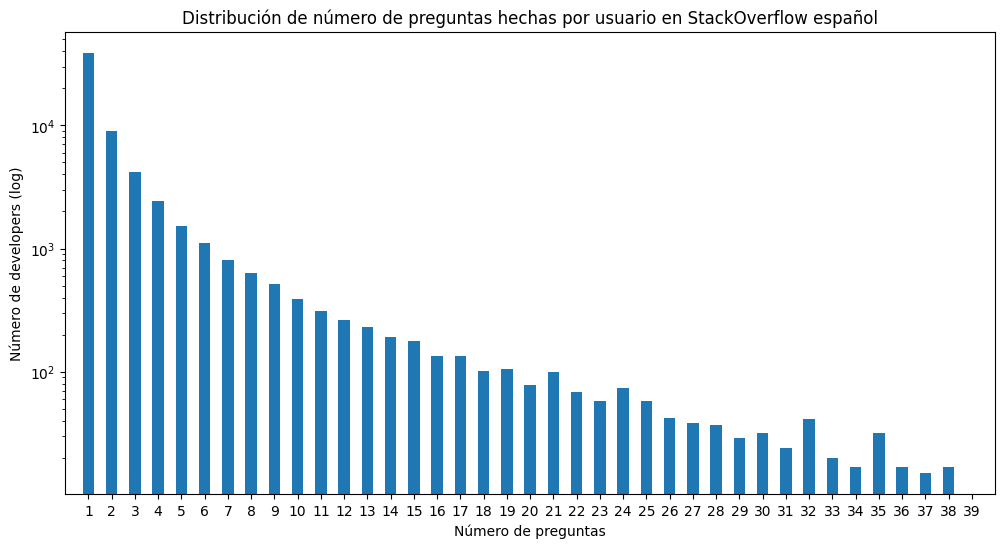

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize= (12,6))
plt.hist(question_count['QuestionCount'], 
        bins=np.arange(1,40)-0.5, # type: ignore
        range = (1,40), log=True, rwidth = 0.5) 
plt.xlim(0,40)
plt.xticks(range(1,40))
plt.title('Distribución de número de preguntas hechas por usuario en StackOverflow español')
plt.xlabel('Número de preguntas')
plt.ylabel('Número de developers (log)')
plt.show()

Finalmente, respondemos a las preguntas propuestas en la respuesta original. Aquí, definimos los usuarios activos como aquellos que han realizado al menos una pregunta o una respuesta. Además, generamos una nueva tabla igual que la anterior pero con una agrupación de todos los usuarios activos.

In [14]:
# Se usara tambien luego
total_count: pa.Table = (
    posts.to_table(filter=pc.field('PostTypeId').isin([1,2]))
        .group_by("OwnerUserId")
        .aggregate([("Id", "count")])
        .drop_null()
        .rename_columns(["OwnerUserId", "TotalCount"])
)

active_users = total_count.num_rows
active_with_questions = question_count.num_rows

users_1q = question_count.filter(pc.field("QuestionCount") == 1).num_rows
users_more1q = active_with_questions - users_1q
users_more5q = question_count.filter(pc.field("QuestionCount") > 5).num_rows

prop_pregunta = active_with_questions / active_users
prop_1 = users_1q / active_with_questions
prop_more1q = users_more1q / active_with_questions
prop_more5q = users_more5q / active_with_questions

print(f"Total de usuarios con preguntas: {active_with_questions} ({prop_pregunta:.2%} de los usuarios activos)")
print(f"Usuarios que hicieron solo 1 pregunta: {users_1q} ({prop_1:.2%} de los que preguntan)")
print(f"Usuarios que hicieron 2 o más preguntas: {users_more1q} ({prop_more1a:.2%} de los que preguntan)")
print(f"Usuarios que hicieron más de 5 preguntas: {users_more5q} ({prop_more5q:.2%} de los que preguntan)")

Total de usuarios con preguntas: 61993 (78.79% de los usuarios activos)
Usuarios que hicieron solo 1 pregunta: 38481 (62.07% de los que preguntan)
Usuarios que hicieron 2 o más preguntas: 23512 (37.93% de los que preguntan)
Usuarios que hicieron más de 5 preguntas: 6393 (10.31% de los que preguntan)


### RQ2: Distribution of Answerers

Para la resolución de la tarea RQ2 se pide un histograma similar al realizado en la tarea anterior pero esta vez con las respuestas a preguntas, añadiendo también de aquellos usuarios activos los que no han respondido a ninguna pregunta. Igualmente, se nos pide responder algunas preguntas semejantes a las realizadas en la RQ1.

Para resolver esta cuestión comenzamos con la creación de una tabla de agregación como en el caso anterior, pero para añadir el dato del número de developers que no ha creado ninguna respuesta debemos crear otra tabla de agregación que contenga la distribución que antes se creaba automáticamente al crear el histograma.

Para añadir el dato, creamos una tabla que solo contiene esa entrada y la concatenamos con la tabla que contiene la distribución.

In [10]:
answer_count: pa.Table = (
    posts.to_table(filter=pc.field("PostTypeId") == 2)
    .group_by("OwnerUserId")
    .aggregate([("Id", "count")])
    .drop_null()
    .rename_columns(["OwnerUserId", "AnswerCount"])
)

active_with_answers = answer_count.num_rows
users_zero_answers = active_users - active_with_answers

distribution: pa.Table = (
    answer_count.group_by("AnswerCount")
    .aggregate([("OwnerUserId", "count")])
    .rename_columns(["AnswerCount", "UserCount"])
)

zero_answers = pa.Table.from_pydict({"AnswerCount":[0], "UserCount":[users_zero_answers]})
distribution = pa.concat_tables([distribution, zero_answers])

Dado que ahora tenemos la distribución directamente, no debemos generar el histograma, sino un gráfico de barras.

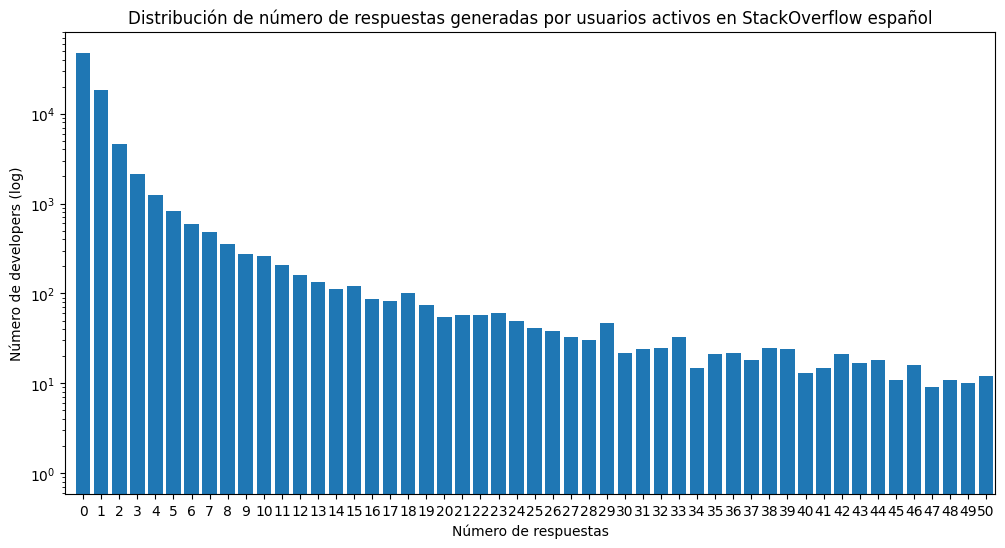

In [11]:
plt.figure(figsize=(12, 6))
plt.bar(
    distribution["AnswerCount"],
    distribution["UserCount"],
    log=True,
)
plt.xlim((-1, 50.5))
plt.xticks(range(51))
plt.title(
    "Distribución de número de respuestas generadas por usuarios activos en StackOverflow español"
)
plt.xlabel("Número de respuestas")
plt.ylabel("Número de developers (log)")
plt.show()

In [16]:
users_1q = question_count.filter(pc.field("QuestionCount") == 1).num_rows
users_more1a = active_users - users_1q
users_more5a = question_count.filter(pc.field("QuestionCount") > 5).num_rows

users_1a = answer_count.filter(pc.field("AnswerCount") == 1).num_rows
users_more1a = active_with_answers - users_1a
users_more5a = answer_count.filter(pc.field("AnswerCount") > 5).num_rows
max_answers = pc.max(answer_count["AnswerCount"]).as_py()

prop_respuesta = (active_with_answers / active_users) 
prop_1 = (users_1a / active_with_answers) 
prop_more1a = (users_more1a / active_with_answers) 
prop_more5a = (users_more5a / active_with_answers) 

print(f"Total de usuarios con preguntas: {active_with_answers} ({prop_respuesta:.2%} de los usuarios activos)")
print(f"Usuarios que hicieron solo 1 pregunta: {users_1q} ({prop_1:.2%} de los que responden)")
print(f"Usuarios que hicieron 2 o más preguntas: {users_more1a} ({prop_more1a:.2%} de los que responden)")
print(f"Usuarios que hicieron más de 5 preguntas: {users_more5a} ({prop_more5a:.2%} de los que responden)")
print(f"Número máximo de respuestas de un usuario: {max_answers}")
print(f"Usuarios que responden a más de 5 preguntas {users_more5a} frente a usuarios que preguntan más de 5 veces {users_more5q}")

Total de usuarios con preguntas: 31650 (40.23% de los usuarios activos)
Usuarios que hicieron solo 1 pregunta: 38481 (58.43% de los que responden)
Usuarios que hicieron 2 o más preguntas: 13156 (41.57% de los que responden)
Usuarios que hicieron más de 5 preguntas: 4438 (14.02% de los que responden)
Número máximo de respuestas de un usuario: 5728
Usuarios que responden a más de 5 preguntas 4438 frente a usuarios que preguntan más de 5 veces 6393


### RQ3: Segregation of StackOverflow Community
To answer this research question, we investigate the proportion of posts that various developers make that are answers to some questions. We show this in Figure 5. We notice that a majority of developers only ask questions but do not answers them (83.2%, 36,672 developers). Thus, we could divide the StackOverflow community into two groups: people that only ask questions, and those that answer one or more questions. The first group is the majority.

We also note another peak in Figure 5: These are developers (2,956 of 44,087 developers), with 50-59% of posts being answers. These correspond to ideal developers that contribute answers to the community as much as requesting answers from the community.

### RQ4: RQ4: Reciprocity in StackOverflow
To answer the fourth research question, we investigate the help graph. A help graph is a directed graph, where each developer is a node, and the node corresponding to a developer D1 is linked to that of D2 if D1 answers a question posted by D2. We would like to investigate how often two developers D1 and D2 are connected by two edges, one from D1 to D2 and the other from D2 to D1. We find that there are only a few of such developers (23 pairs). We highlight a few in Table 1. The table contains the identifiers of the helpers and helpees that reciprocate. From the result, we hypothesize that developers tend to help anyone no matter if they have helped him or her before and StackOverflow tends to benefit the community as a whole.